In [25]:
import numpy as np
import os
import time

In [26]:
# utf 8
import re

standardize_map = {
    'ê': 'e', 'è': 'e', 'é': 'e', 'ë': 'e', 'Ê' : 'E',
    'à': 'a', 'á': 'a', 'â': 'a', 'ä' : 'a', 'ă' :'a',
    'î': 'i', 'ì': 'i', 'í': 'i', 'ï': 'i',
    'ô': 'o', 'ò': 'o', 'ó': 'o', 'ö': 'o',
    'ù': 'u', 'ú': 'u', 'û': 'u', 'ü': 'u'
}

def standardize_text(text):
    for diacritic_char, standard_char in standardize_map.items():
        text = text.replace(diacritic_char, standard_char)
    return text

with open('scrapped.txt', 'r', encoding='utf-8') as file:
    text = file.read()
    file.close()

standardized_text = standardize_text(text).lower()

with open('standardized.txt', 'w', encoding='utf-8') as file:
    file.write(standardized_text)
    file.close()



In [27]:
# remove punc
import re
import string

def remove_punctuation(text):

    pattern = f"[{re.escape(string.punctuation)}]"
    text_no_punctuation = re.sub(pattern, "", text)

    return text_no_punctuation

v2_standardized_text = remove_punctuation(standardized_text)

with open('standardized-2.txt', 'w', encoding='utf-8') as file:
    file.write(v2_standardized_text)
    file.close()


In [28]:
# remove empty lines
def remove_empty_lines(text):
    lines = text.split("\n")

    non_empty_lines = [line for line in lines if line.strip()]

    cleaned_text = "\n".join(non_empty_lines)

    return cleaned_text


v3_standardized_text = remove_empty_lines(v2_standardized_text)

with open('standardized-3.txt', 'w', encoding='utf-8') as file:
    file.write(v3_standardized_text)
    file.close()

In [29]:
# count
def count_words(text):
    words = text.split()
    return len(words)

word_count = count_words(v2_standardized_text)

print("total :", word_count)


total : 9365


In [30]:
# unique
def get_unique_words(text):
    words = text.split()

    unique_words = set(word.lower() for word in words)

    return list(unique_words)

unique_words = get_unique_words(v3_standardized_text)
length_of_unique_words = len(unique_words)

print("Jumlah Kata Unik:", len(unique_words))


Jumlah Kata Unik: 2885


In [31]:
# [[],[]]
def text_to_2d_list(text):

    lines = text.split("\n")

    words_2d_list = [line.split() for line in lines if line.strip()]

    return words_2d_list


words_2d_list = text_to_2d_list(v3_standardized_text)

print(words_2d_list[:2])
# v3_standardized_text


[['lingkup', 'pencarian', 'teks', 'dan', 'catatankakinya', 'teks', 'pencarian', '224', 'karakter', 'filter', 'pencarian', 'huruf', 'besarkecil', 'diakritik', 'serta', 'pungtuasi', 'diabaikan', 'karakter', 'dapat', 'digunakan', 'sebagai', 'pengganti', 'zero', 'atau', 'satu', 'huruf', 'sembarang', 'simbol', 'wildcard', 'dapat', 'digunakan', 'sebagai', 'pengganti', 'zero', 'atau', 'sejumlah', 'karakter', 'termasuk', 'spasi', 'mengakomodasi', 'variasi', 'ejaan', 'antara', 'lain', 'dj', 'j', 'tj', 'c', 'j', 'y', 'oe', 'u', 'd', 'dh', 't', 'th'], ['anggitanipun', 'dawud', 'magang', 'guru', 'ing', 'masaran']]


In [32]:
def build_indices(unique_words):
    word_to_idx = {}
    idx_to_word = {}
    for i, word in enumerate(unique_words):
        word_to_idx[word] = i
        idx_to_word[i] = word
    return word_to_idx, idx_to_word

word_to_idx, idx_to_word = build_indices(unique_words)

In [33]:
# word_to_idx

for i, (word, idx) in enumerate(word_to_idx.items()):
    print(f"{word}: {idx}")
    if i == 9:
        break


upaya: 0
matura: 1
lir: 2
becike: 3
pejahi: 4
karaos: 5
cecak: 6
babut: 7
cariyos: 8
wedi: 9


In [34]:
def prepare_corpus(corpus, word_to_idx):
    sequences = []

    for line in corpus:
        tokens = line
        missing_tokens = [token for token in tokens if token not in word_to_idx]

        for token in missing_tokens:
            word_to_idx[token] = len(word_to_idx)
            print(f"Token '{token}' ditambahkan ke word_to_idx.")

        for i in range(1, len(tokens)):
            i_gram_sequence = tokens[:i+1]
            i_gram_sequence_ids = [
                word_to_idx[token] for token in i_gram_sequence
            ]
            sequences.append(i_gram_sequence_ids)

    return sequences

sequences = prepare_corpus(words_2d_list, word_to_idx)
max_sequence_len = max([len(x) for x in sequences])

In [35]:
sequences[0]

[773, 686]

In [36]:
print(idx_to_word[1647])
print(idx_to_word[867])
print(idx_to_word[1452])

tetinggalaku
angakenana
kosusahake


In [37]:
len(sequences)

9210

In [38]:
max_sequence_len

146

In [39]:
from keras.preprocessing.sequence import pad_sequences
from keras import utils
import numpy as np

def build_input_data(sequences, max_sequence_len, length_of_unique_words):
    sequences = np.array(pad_sequences(sequences, maxlen = max_sequence_len, padding = 'pre'))
    X = sequences[:,:-1]
    y = sequences[:,-1]
    y = utils.to_categorical(y, length_of_unique_words)
    return X, y

X, y = build_input_data(sequences, max_sequence_len, length_of_unique_words)


In [40]:
from keras.layers import Dense, LSTM, Dropout, Embedding, BatchNormalization, Bidirectional
from keras.models import Sequential

def create_model(max_sequence_len, length_of_unique_words):
    model = Sequential([
        Embedding(length_of_unique_words, 64, input_length= max_sequence_len-1),
        Bidirectional(LSTM(64,return_sequences=True)),
        Bidirectional(LSTM(64)),
        BatchNormalization(),
        Dense(128, activation="relu"),
        Dense(length_of_unique_words, activation="softmax")
    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model


In [41]:
model = create_model(max_sequence_len, length_of_unique_words)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
len(X)

9210

In [43]:
history = model.fit(X,y, batch_size = 512, epochs=75)

Epoch 1/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.0062 - loss: 7.9049
Epoch 2/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.0229 - loss: 7.0651
Epoch 3/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.0339 - loss: 6.6975
Epoch 4/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.0355 - loss: 6.6086
Epoch 5/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.0327 - loss: 6.5415
Epoch 6/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.0373 - loss: 6.4109
Epoch 7/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.0344 - loss: 6.3079
Epoch 8/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.0358 - loss: 6.1855
Epoch 9/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.0383 - loss: 6.0113
Epoch 10/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.0422 - loss: 5.8792
Epoch 11/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.0527 - loss: 5.6722
Epoch 12/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy:

In [44]:
import matplotlib.pyplot as plt
def render_loss_graph(history):
    loss = history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

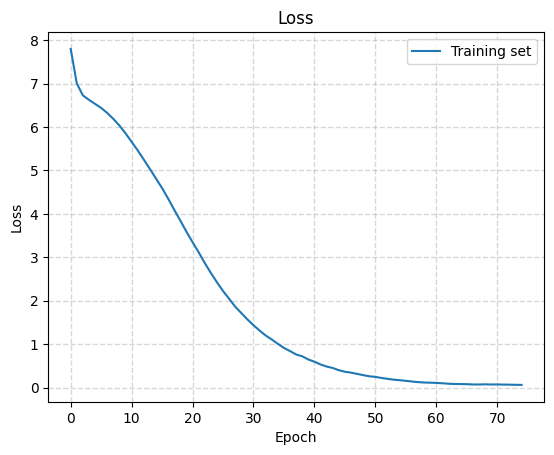

In [45]:
render_loss_graph(history)

In [46]:
# def generate_text(seed_text, next_words, model, max_seq_len):
#     for _ in range(next_words):
#         sequences= prepare_corpus(words_2d_list[2], word_to_idx)
#         sequences = pad_sequences([sequences[-1]], maxlen=max_seq_len-1, padding='pre')
#         predicted = model.predict_classes(sequences, verbose=0)
#         output_word = ''
#         output_word = idx_to_word[predicted[0]]
#         seed_text = seed_text + " " + output_word

#     return seed_text.title()

from keras.preprocessing.sequence import pad_sequences

def generate_text(seed_text, next_words, model, max_seq_len, word_to_idx, idx_to_word):
    for _ in range(next_words):
        tokens = seed_text.split()
        token_sequence = [word_to_idx.get(token, 0) for token in tokens]

        padded_sequence = pad_sequences([token_sequence], maxlen=max_seq_len - 1, padding='pre')

        predicted_index = np.argmax(model.predict(padded_sequence, verbose=0))
        predicted_word = idx_to_word[predicted_index]

        seed_text += f" {predicted_word}"

    return seed_text


In [47]:
print(generate_text("kacariyos ing jaman", 30, model, max_sequence_len, word_to_idx, idx_to_word))

kacariyos ing jaman kina wonten satunggiling warandha sampun sepuh anama bok randha sambega gegriya wonten ing padhekahan alit anama padhekahan sidhangmiring bawah ing sukawati sang nata utusan animbali bok randha sambega bupati gadhah


In [48]:
model_structure = model.to_json()
with open("v1_text_generation.json", "w") as json_file:
    json_file.write(model_structure)
model.save_weights("v1_text_generation.weights.h5")